# 使用 eventproxy 控制并发

## 目标

建立一个 `lesson4` 项目，在其中编写代码。

代码的入口是 `app.js` ，当调用 `node app.js` 时，它会输出 [CNode](https://cnodejs.org/) 社区首页的所有主题的标题，连接和第一条评论，以 `json` 的格式。

输出示例：

```
[
  {
    "title": "【公告】发招聘帖的同学留意一下这里",
    "href": "http://cnodejs.org/topic/541ed2d05e28155f24676a12",
    "comment1": "呵呵呵呵"
  },
  {
    "title": "发布一款 Sublime Text 下的 JavaScript 语法高亮插件",
    "href": "http://cnodejs.org/topic/54207e2efffeb6de3d61f68f",
    "comment1": "沙发！"
  }
]
```

## 挑战

以上文目标为基础，输出 `comment1` 的作者，以及他在 `cnode` 社区的积分值。

示例：

```
[
  {
    "title": "【公告】发招聘帖的同学留意一下这里",
    "href": "http://cnodejs.org/topic/541ed2d05e28155f24676a12",
    "comment1": "呵呵呵呵",
    "author1": "auser",
    "score1": 80
  },
  ...
]
```

## 知识点

1. 体会 `Node.js` 的callback hell 之美
2. 学习使用 `eventproxy` 这一利器控制并发

## 课程内容

注意， [cnodejs.org](http://cnodejs.org/) 网站有并发连接数的限制，所以当请求发送太快的时候会导致返回值为空或报错。建议一次抓取 3 个主题即可。文中的 40 只是为了方便讲解

这一章我们来到了 `Node.js` 最牛逼的地方 —— 异步并发的内容了。

上一课我们介绍了如何使用 `superagent` 和 `cheerio` 来取主页内容，那只需要发起一次 `http get` 请求就能办到。但这次，我们需要取出每个主题的第一条评论，这就要求我们对每个主题的链接发起请求，并用 `cheerio` 去取出其中的第一条评论。

`CNode` 目前每一页有 40 个主题，于是我们就需要发起 1 + 40 个请求，来达到我们这一课的目标。

* [选择题 ★ 以下线程、进程和程序的描述，哪个选项是错误的？](https://xue.cn/hub/app/exercise/1947)
* [选择题 ★ 关于进程和线程的关系，以下哪个说法正确？](https://xue.cn/hub/app/exercise/1952)

后者的 40 个请求，我们并发地发起:),而且不会遇到多线程啊锁什么的， `Node.js`的并发模型跟多线程不同，抛却那些观念。更具体一点的话，比如异步到底为何异步， `Node.js` 为何单线程却能并发这类走近科学的问题，我就不打算讲了。对于这方面有兴趣的同学，强烈推荐 @朴灵 的[《九浅一深 Node.js》](http://book.douban.com/subject/25768396/)。

有些逼格比较高的朋友可能听说过 `promise` 和 `generator` 这类概念。不过我呢，只会讲 `callback`,主要原因是我个人只喜欢 `callback`。

这次课程我们需要用到三个库：`superagent` `cheerio` [eventproxy](https://github.com/JacksonTian/eventproxy)

脚手架的工作各位自己来，我们一步一步来一起写出这个程序。

首先 `app.js` 应该长这样

```
var eventproxy = require('eventproxy');
var superagent = require('superagent');
var cheerio = require('cheerio');
// url 模块是 Node.js 标准库里面的
// http://nodejs.org/api/url.html 
var url = require('url');

var cnodeUrl = 'https://cnodejs.org';

superagent.get(cnodeUrl)
    .end(function(err, res){
        if (err) {
            return console.error(err);
        }
        var topicUrls = [];
        var $ = cheerio.load(res.text);
        // 获取首页所有的链接
        $('#topic_list .topic_title').each(function (idx, element) {
            var $element = $(element);
            // $element.attr('href') 本来的样子是 /topic/542acd7d5d28233425538b04
            // 我们用 url.resolve 来自动推断出完整 url，变成
            // https://cnodejs.org/topic/542acd7d5d28233425538b04 的形式
            // 具体请看 http://nodejs.org/api/url.html#url_url_resolve_from_to 的示例
            var href = url.resolve(cnodeUrl,$element.attr('href'));
            topicUrls.push(href);
        });
        console.log(topicUrls);
    });
```
运行 `node app.js`

输出如下图：

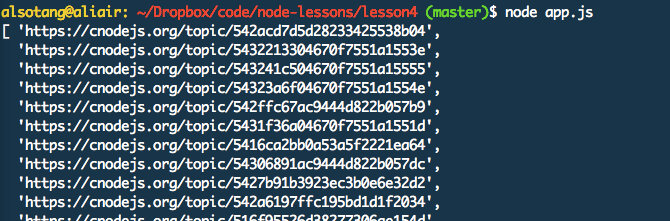

OK,这时候我们已经得到所有 `url` 的地址了，接下来，我们把这些地址都抓取一遍，就完成了， `Node.js` 就是这么简单。

抓取之前，还是得介绍一下 `eventproxy` 这个库。

用 `js` 写过异步的同学应该都知道，如果你要并发异步获取两三个地址的数据，并且要在获取到数据之后，对这些数据一起进行利用的话，常规的写法是自己维护一个计数器。

先定义一个 `var count = 0`,然后每次抓取成功以后，就 `count++`。如果你是要抓取三个源的数据，由于你根本不知道这些异步操作到底谁先完成，那么每次当抓取成功的时候，就判断一下 `count === 3`。当值为真时，使用另一个函数继续完成操作。

而 `eventproxy` 就起到了这个计数器的作用，它来帮你管理到底这些异步操作是否完成，完成之后，它会自动调用你提供的处理函数，并将抓取到的数据当参数传过来。

假设我们不使用 `eventproxy` 也不使用计数器时，抓取三个源的写法是这样的:

```
// 参考 jquery 的 $.get 的方法
$.get("http://data1_source",function(data1){
    // something $.get("http://data2_source", function (data2) {
        // something $.get("http://data3_source", function (data3) {
            //something var html = fuck(data1, data2, data3);
            render(html);
        });
    });
});
```
上述的代码大家都写过吧。先获取 `data1`,获取完成之后获取 `data2`,然后再获取 `data3`,然后 `fuck` 它们，进行输出。

但大家应该也想到了，其实这三个源的数据，是可以并行去获取的，`data2` 的获取并不依赖 `data1` 的完成，`data3` 同理也不依赖 `data2`。

于是我们用计数器来写，会写成这样：

```
(function (){
  var count = 0;
  var result = {};
  
  $.get('http://data1_source', function (data) {
    result.data1 = data;
    count++;
    handle();
  });
  
  $.get('http://data2_source',function (data){
    result.data2 = data;
    count++;
    handle();
  });
  
  $.get('http://data3_source',function (data){
    result.data3 = data;
    count++;
    handle();
  });
  
  function handle() {
    if (count === 3) {
      var html = funk(result.data1, result.data2, result.data3);
      render(html);
    }
  }
})();
```

```
<del>
丑的一逼
</del>
```
也不算丑，主要我写代码好看。

如果我们用 `eventproxy`,写出来是这个样子的：

```
var ep = new eventproxy();

ep.all('data1_event', 'data2_event', 'data3_event',function(data1, data2, data3){
    var html = fuck(data1, data2, data3);
    render(html);
});

$.get('http://data1_source', function (data) {
  ep.emit('data1_event', data);
  });

$.get('http://data2_source', function (data) {
  ep.emit('data2_event', data);
  });

$.get('http://data3_source', function (data) {
  ep.emit('data3_event', data);
  });
```
好看多了是吧，也就是个高等计数器嘛。

```
ep.all('data1_event', 'data2_event', 'data3_event', function (data1, data2, data3) {});
```

这一句，监听了三个事件，分别是 `data1_event, data2_event, data3_event`,每次当一个源数据抓取完成时，就通过 `ep.emit()` 来告诉 `ep` 自己，某某事件已经完成了。

当三个事件未同时完成时，`ep.emit()` 调用之后不会做任何事；当三个事件都完成的时候，就会调用末尾的那个回调函数，来对它们进行统一处理。

`eventproxy` 提供了不少其他场景所需的 `API` ,但最最常用的用法就是以上的这种，即：

1. 先 `var ep = new eventproxy();` 得到一个 `eventproxy` 实例。
2. 告诉它你要监听哪些事件，并给它一个回调函数。 `ep.all('event1', 'event2', function(result1, result2){})`。
3. 再适当的时候 `ep.emit('event_name', eventData)`。

`eventproxy` 这套处理异步并发的思路，我一直觉得就像时汇编里面的 `goto` 语句一样，程序逻辑在代码中随处跳跃。本来代码已经执行到 100 行了，突然 80 行的那个回调函数又开始工作了。如果你异步逻辑复杂点的话，80 行的这个函数完成之后，又激活了 60 行的另外一个函数。并发和嵌套的问题虽然解决了，但老祖宗们消灭了几十年的 `goto` 语句又回来了。

至于这套思想糟糕不糟糕，我个人倒是觉得还是不糟糕，用熟了看起来蛮清晰的。不过 js 这门渣渣语言本来就乱嘛，什么变量提升（http://www.cnblogs.com/damonlan/archive/2012/07/01/2553425.html） 啊，没有main函数啊，变量作用域啊，数据类型常常简单得只有数字、字符串、哈希、数组啊，这一系列的问题，都不是事儿。

* [选择题 ★ JavaScript 代码 console.log(a);var a=12; 将打印出什么？](https://xue.cn/hub/app/exercise/2042)

编程语言美丑啥的，咱心中有佛就好。

* [判断题 ★ JavaScript 从上往下逐行执行每行代码。下方代码运行将报错提示变量未声明。这个说法正确吗？](https://xue.cn/hub/app/exercise/2035)

回到正题，之前我们已经得到了一个长度为 40 的 `topicUrls` 数组，里面包含了每条主题的链接。那么意味着，我们接下来要发出 40 个并发请求。我们需要用到 `eventproxy` 的 `#after` API。

大家自行学习一下这个 API 吧：https://github.com/JacksonTian/eventproxy#重复异步协作

我代码就直接贴了哈。

```
// 得到 topicUrls 之后

// 得到一个 eventproxy 的实例
var ep = new eventproxy();

// 命令 ep 重复监听 topicUrls.length 次（在这里也就是 40 次）`topic_html` 事件再行动
ep.after('topic_html', topicUrls.length, function (topics) {
  // topics 是个数组，包含了 40 次 ep.emit('topic_html', pair) 中的那 40 个 pair

  // 开始行动
  topics = topics.map(function (topicPair) {
    // 接下来都是 jquery 的用法了
    var topicUrl = topicPair[0];
    var topicHtml = topicPair[1];
    var $ = cheerio.load(topicHtml);
    return ({
      title: $('.topic_full_title').text().trim(),
      href: topicUrl,
      comment1: $('.reply_content').eq(0).text().trim(),
    });
  });

  console.log('final:');
  console.log(topics);
});

topicUrls.forEach(function (topicUrl) {
  superagent.get(topicUrl)
    .end(function (err, res) {
      console.log('fetch ' + topicUrl + ' successful');
      ep.emit('topic_html', [topicUrl, res.text]);
    });
});

```

输出长这样：

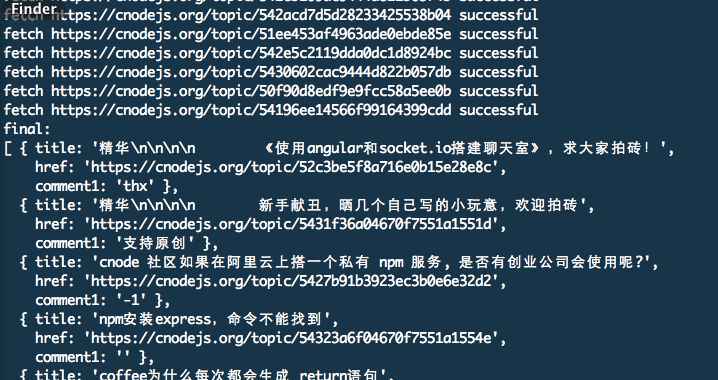

完整的代码请查看 lesson4 目录下的 app.js 文件